<a href="https://colab.research.google.com/github/victoriousvictor42/Sales-Forecasting/blob/main/Sales_Forecasting_Using_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Time Series Forecating


---

## Objective
Forecast the next 12 months of product sales using time series models to identify trends, seasonality, and improve business planning.


---

## Delivarables


*   Time series decomposition - trend, seasonality, residuals
*   Modeling - ARIMA, Prophet, or LSTM
*   Evaluation metrics - MAE, RMSE
*   Forecast visualization - Line plots, confidence intervals







## 2. Import libraries

In [7]:
%pip install statsmodels prophet statsforecast --quiet --upgrade

In [8]:
# importing basic libraries for daa handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for decomposing timeseries into trend, seasonality, residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# forecasting library (AutoARIMA, SARIMA, etc)
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Prophet model for time series forecasting
from prophet import Prophet

# Evaluation metrics to measure forecasting accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## 3. Generate Synthetic Sales Data

Since we don't use real sales data here, we generate a synthetic dataset for this dataset. This creates a realistic-looking sales time series with both randomness and trend.

---
### 3.1 Synthetic Data Generation


*   pd.date_range → Creates a monthly date range starting from January 2020 with 36 periods (3 years)
*   np.random.poisson → Simulates random sales values around a mean (λ=200)
*   np.linspace(0,100,36) → Adds a small upward trend over time
*   pd.DataFrame → Combines the dates and sales into a clean dataset







In [11]:
# Generate a date range of 36 months starting from Jan 2020
date_range = pd.date_range(start='2020-01-01',periods=36,freq='M')

# Create synthetic sales data with a base Poisson Distribution + upward trend
sales = np.random.poisson(lam=200,size=36) + np.linspace(0,100,36)

# Build Dataframe with Date and Sales values
df = pd.DataFrame({'Date':date_range,'Sales':sales.round(2)})


In [12]:
# Preview the first 5 rows
df.head()

,Date,Sales
0,2020-01-31,212.00
1,2020-02-29,195.86
2,2020-03-31,201.71
3,2020-04-30,228.57
4,2020-05-31,225.43


In [13]:
# Preview the last 5 rows
df.tail()

,Date,Sales
31,2022-08-31,288.57
32,2022-09-30,288.43
33,2022-10-31,268.29
34,2022-11-30,305.14
35,2022-12-31,284.00


In [15]:
df.shape

(36, 2)

there are 36 rows and 2 columns

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.0 bytes


In [17]:
# Summary statistics
df.describe()

,Date,Sales
count,36,36.000000
mean,2021-07-15 21:20:00,249.027778
min,2020-01-31 00:00:00,195.860000
25%,2020-10-23 06:00:00,226.500000
50%,2021-07-15 12:00:00,248.355000
75%,2022-04-07 12:00:00,270.640000
max,2022-12-31 00:00:00,305.140000
std,NaN,30.682372


## 4. Exploratory Data Analysis (EDA)

We perform EDA to understand our synthetic sales dataset and identify trends, seasonality, and anomalies.

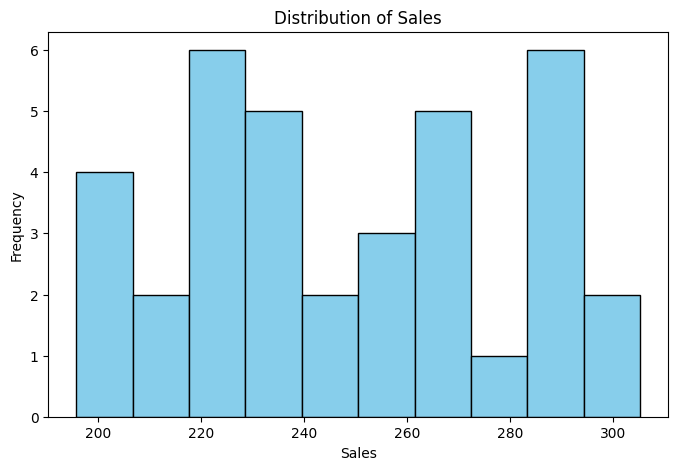

In [19]:
# Set figure size for the histogram
plt.figure(figsize=(8,5))

# Plot histogram of sales to visualize the distribution
plt.hist(df['Sales'],bins=10, color='skyblue', edgecolor='black')

# Add title and axis labels
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Display the plot
plt.show()

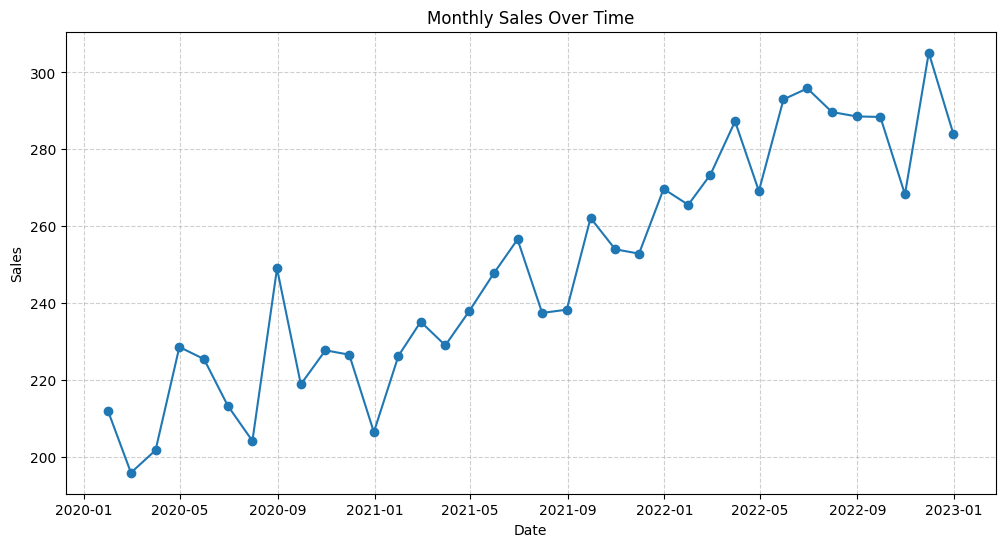

In [25]:
# Set figure size for the line plot
plt.figure(figsize=(12,6))

# Plot monthly sales over time with markers
plt.plot(df['Date'],df['Sales'],marker='o',linestyle='-')

# Add title and axis labels
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add grid for better readability
plt.grid(True,linestyle="--",alpha=0.6)

# Display the plot
plt.show()

In [ ]:
# calculate 6-month rolling mean and standard deviation
df_roll = df.copy()
r